````{grid} 2
```{grid-item-card}
:class-header: bg-light
Voraussetzungen
^^^
- mathematisches und numerisches Grundverständnis
```
```{grid-item-card}
:class-header: bg-light
Lerninhalte
^^^
- Nachvollziehen eines Beispiels zur Implementierung des Finite-Volumen-Verfahrens mit der WENO-Methode
```
````


(traffic_pde)=
# Verkehrssimulation mit finiten Volumen

In dem Kapitel {ref}`traffic_motivation` haben wir ein Beispiel zur Verkehrssimulation kennengelernt. Mit partiellen Differentialgleichungen können wir auch unser Verkehrsmodell wesentlich realistischer lösen und verschiedene Situationen simulieren. In diesem Kapitel ist dafür ein Beispiel gegeben. Unten finden Sie die grafische Ausgabe aus Matlab.

## Aufstellen einer partiellen Differentialgleichung

Der Situation liegt ein Transportproblem zugrunde:

$$0=\frac{\partial \rho}{\partial t} + \frac{\partial}{\partial x}(\rho u)$$

Für die Geschwindigkeit lässt sich eine Funktion abhängig von der lokalen Verkehrsdichte aufstellen:

$$u(\rho) = \left\{ \begin{matrix} u_\text{max} & \text{, falls } \rho < \rho_\text{krit}\\ c \cdot \ln \left( \frac{\rho}{\rho_\text{max}}\right) & \text{, falls } \rho \ge \rho_\text{krit}\end{matrix} \right. $$

Das bedeutet, dass bis zu einer kritischen Verkehrsdichte alle Fahrzeuge mit der maximal möglichen Geschwindigkeit fahren können. Danach nimmt die durchschnittliche Geschwindigkeit logarithmisch ab, bis alle Fahrzeuge bei der maximalen Dichte direkt hintereinander zum Stillstand kommen. In der unten stehenden Grafik ist als maximale Geschwindigkeit $130 \frac{\text{km}}{\text{h}}$, für die kritische Dichte $\frac{1 \text{ Fahrzeug}}{100 \text{ m}}$ und für die maximale Dichte $\frac{1 \text{ Fahrzeug}}{6 \text{ m}}$ angenommen.

```{admonition} Hinweis
Diese Funktion lässt sich auch mit dem Nagel-Schreckenberg-Modell herleiten, siehe dazu die Übung {ref}`naschr`.
```

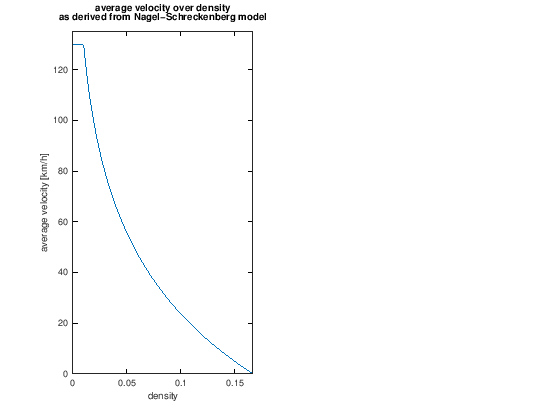

In [ ]:
% if your Octave kernel does not plot, write `graphics_toolkit("gnuplot")`
rho = linspace(0,rho_max,100);
rho_krit = 1/100;
u_max = 130;
rho_max = 1/6;
c = u_max/log(rho_krit/rho_max);

for i = 1:length(rho)
  if rho(i) < rho_krit
      u(i) = u_max;
  else
      u(i) = c*log(rho(i)/rho_max);
  end
end

figure
subplot(1,2,1);
plot(rho,u)
ylim([0,u_max+5])
xlim([0,rho_max])
title({'average velocity over density','as derived from Nagel-Schreckenberg model'});
xlabel('density');
ylabel('average velocity [km/h]');
drawnow

<div style=\"text-align: right\"> Abbildung 1: Durchschnittliche Geschwindigkeit in Kilometer pro Stunde über Fahrzeugdichte in Autos pro Meter. Der Zusammenhang wurde aus dem Nagel-Schreckenberg Modell abgeleitet.</div> <br>

## Graphische Darstellung

Leider funktioniert die dynamische graphische Darstellung in Octave nicht. Stattdessen können Sie den untenstehenden Code herunterladen und in Matlab ausführen.

```{image} images/highway_jam.gif
:alt: "highway_jam"
:width: 800px
:align: center
```
<div style=\"text-align: right\"> Abbildung 2: Auflösung eines Staus auf einem Straßenabschnitt.</div> <br>

```{image} images/highway_light_green.gif
:alt: "highway_light_green"
:width: 800px
:align: center
```
<div style=\"text-align: right\"> Abbildung 3: Straßenabschnitt beim Losfahren von einer grünen Ampel.</div> <br>

```{image} images/highway_light_red.gif
:alt: "highway_light_red"
:width: 800px
:align: center
```
<div style=\"text-align: right\"> Abbildung 4: Straßenabschnitt beim Auffahren an eine rote Ampel.</div> <br>

In [ ]:
function autobahn
%-- mit FV WENO-Verfahren 3. Ordnung
clear all
%--
global u_max rho_max rho_krit c
u_max = 50; % 180 km/h
rho_max = 1/6; % 1 Auto auf 6 m
rho_krit = 1/100; 
c = u_max/log(rho_krit/rho_max);
global x dx n
n = 100; dx = 100000/n;
x = linspace(dx/2, 100000-dx/2, n); %-- Zellenmittelpunkte
%-- Steuauflösung
y0 = 0.1*exp(-1.0e-6*(x-10000).^2); tspan = [0, 6000];
%-- Ampel gruen
%y0 = 0*x; ff = find(x < 50000); y0(ff)=1/6; tspan = [0, 900];
%-- Ampel rot
%y0 = 0*x+1/100; ff = find(x > 70000); y0(ff)=1/6; tspan = [0, 1400];
%-- Integrator
tol = 1.0e-4;
options=odeset('Stats','on','RelTol',tol,'AbsTol',tol,'OutputFcn',@plot_sol);
tic
[t,y] = ode45(@dgl,tspan,y0,options);
toc
nt = length(t)

function dy = dgl(t,y)
global x dx n
%--
nord = 3;
rho = y'; % Zellenmittelwerte 1,..,n als Zeilenvektor
[rhoL,rhoR]=mc_extrapol(rho);  % rho auf x_1/2 bzw. x_n+1/2 extrapolieren
rho = [rhoL,rho,rhoR];
[rho_m,rho_p]=mc_recover_pcweno(rho,nord);  % Werte auf Zellgrenzen interpolieren
u_m = uvonrho(rho_m); u_p = uvonrho(rho_p); 
q_m = u_m.*rho_m; q_p = u_p.*rho_p; 
lam_m = eigen(rho_m,u_m); lam_p = eigen(rho_p,u_p);
f_r = 0;
for i=1:n+1  % durchlaufe alle Zellgrenzen, der Fluss auf Grenze i heißt f_r
    f_l = f_r;
    lambda = max(lam_m(i),lam_p(i)); 
    f_r = 0.5*( q_m(i)+q_p(i) - lambda*( rho_p(i)-rho_m(i) ) );
    if (i==1) f_r=0; end %-- linke RB
    if (i==n+1 && f_r > 1/3)
        f_r = 1/3;
    end
    if (i>1)
      dy(i-1,1) = -(f_r-f_l)/dx;
    end
end

function status=plot_sol(t,y,flag)
global x dx n
global line_rho line_u
%--
if strcmp(flag,'done') 
    status=0; hold off; return; 
end
rho = y(:,end); u = uvonrho(rho);
if strcmp(flag,'init')
%   subplot(1,2,1)
   axis([x(1), x(n), -0.1, 170]);
   line_rho = line(x, rho*1000,   'Color','red');
   line_u   = line(x, u  ,   'Color','blue');
else
    tt = t(end);
   set(line_rho,'ydata',rho*1000);
   set(line_u  ,'ydata',u);
end
status=0;
legend('1000*\rho','u');
pause(0.1);
drawnow

function u = uvonrho(rho)
global u_max rho_max rho_krit c
%--
u = 0*rho+u_max;
ff = find(rho > rho_krit); u(ff) = c*log(rho(ff)/rho_max);
ff = find(rho > rho_max);  u(ff)=0;

function lam = eigen(rho,u)
global u_max rho_max rho_krit c
%--
lam = u;
ff = find((rho > rho_krit)&(rho < rho_max)); lam(ff) = lam(ff)+c;
lam=abs(lam);

function [yL,yR]=mc_extrapol(y)
%-- Extrapoliere Zellenmittel y der Länge n auf Zellgrenze i=1/2 (=yL) und i=n+1/2 (=yR),
n = length(y);
yR = (3*y(n)-y(n-1))/2; yL=(3*y(1)-y(2))/2; %-- lineare Extrap.

function [yL,yR]=mc_recover_pcweno(y,nord)
%-- Interpoliere Zellenmittelwerte y_i auf Zellgrenzen y_i+1/2
%-- y enthält y_1/2, y_1,...,y_nx,y_nx+1/2
%-- yL enthaelt  y_1/2^-,...,y_nx+1/2^-
%-- yR enthaelt  y_1/2^+,...,y_nx+1/2^+
n = length(y);
i = 1:n-1; ip1=2:n; im1=[1,1:n-2]; ip2=[3:n,n]; 
%-- nx = 1 
if n==3
    yL = [y(1),y(3)]; yR = yL;
    return
end
%-- Extrapolation vom Rand in die Mitte auf -dx/2 bzw. (n+1)*dx
  yL_save = y(1); yR_save = y(n);
  y(1) = 2*y(1) - y(2); y(n) = 2*y(n) - y(n-1);
%---- nord = 1
yR = y(ip1); yL = y(i);   
if nord==2
  sL = y(ip1)-y(i); sR = y(ip2)-y(ip1);  
  r = sL./sR;
  yR = y(ip1) - 0.5*limiter(r).*sR;
%--
  sR = sL; sL = y(i)-y(im1); 
  r = sL./sR;
  yL = y(i) + 0.5*limiter(r).*sR;
%-- Randkorrektur
  yL(1) = yL_save; yR(n-1) = yR_save;
  yR(1) = yL_save; yL(n-1) = yR_save; 
elseif nord==3
  ep = 1.0e-6; p = 0.6; 
  uL = y(ip1)-y(i); uC = y(ip2)-2*y(ip1)+y(i); uR = y(ip2)-y(ip1); uCC = y(ip2)-y(i);
  ISL = uL.^2; ISC = 13/3*uC.^2 +0.25*uCC.^2; ISR = uR.^2;
  aL = 0.25*(1./(ep+ISL)).^p; aC = 0.5*(1./(ep+ISC)).^p; aR = 0.25*(1./(ep+ISR)).^p;
  suma = max(aL+aC+aR,eps);  wL = aL./suma; wC = aC./suma; wR = aR./suma;
  weights = [0.5*wL + 5/12*wC; 0.5*wL+2/3*wC+1.5*wR ;  -wC/12-0.5*wR];
  yR = y(i).*weights(1,:) + y(ip1).*weights(2,:) +y(ip2).*weights(3,:);
%--
  uR = uL; uL = y(i)-y(im1); uC = y(ip1)-2*y(i)+y(im1); uCC = y(ip1)-y(im1);
  ISL = uL.^2; ISC = 13/3*uC.^2 +0.25*uCC.^2; ISR = uR.^2;
  aL = 0.25*(1./(ep+ISL)).^p; aC = 0.5*(1./(ep+ISC)).^p; aR = 0.25*(1./(ep+ISR)).^p;
  suma = max(aL+aC+aR,eps);  wL = aL./suma; wC = aC./suma; wR = aR./suma;
  weights = [weights; -0.5*wL-wC/12; 1.5*wL+2/3*wC+0.5*wR; 5/12*wC+0.5*wR];
  yL = y(im1).*weights(4,:) + y(i).*weights(5,:) + y(ip1).*weights(6,:);
%-- Randkorrektur
  yL(1) = yL_save; yR(n-1) = yR_save;
  yR(1) = yL_save; yL(n-1) = yR_save; 
end

function s = limiter(r)
  r = min(5,max(0,r));
  s = (r.^2+r)./(r.^2+1);  % van Albada